In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import catboost as cbs

# 1. Подготовка данных

### 1.1 Загрузка данных

In [2]:
autos = pd.read_csv('datasets/autos.csv')
print(autos.info())
autos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Много пропусков в столбцах VehicleType и NotRepaired, меньше - в столбцах Gearbox, Model, FuelType. Столбцы DateCrawled, DateCreated и LastSeen может потребоваться перевести к типу данных datetime, если они будут нужны в дальнейшем исследовании.  
Посмотрим на корреляцию данных:

In [3]:
autos.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


Видна слабая связь цены с мощностью двигателя, пробегом и месяцем регистрации (в последнем случае корреляция, видимо, ложная)

#### Дубликаты
Имеется 4 дубликата. Так как в таблице много уникальных данных, в т.ч. даты с точностью до секунды, случайные совпадения исключены. Дубликаты удаляем

In [4]:
print('Дубликаты:', autos.duplicated().sum())
autos[autos.duplicated()]

Дубликаты: 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [5]:
autos = autos.drop_duplicates()

### 1.2 Анализ столбцов

#### Цена
Несмотря на то, что в столбце нет пропусков, есть достаточно много нулевых значений. Это явно недостоверные данные, но заполнять их нельзя, т.к. цена - это целевой признак. Придется удалить все строки с нулевыми и слишком низкими значениями в этом столбце. Определим минимальную доставерную цену в 100 евро.

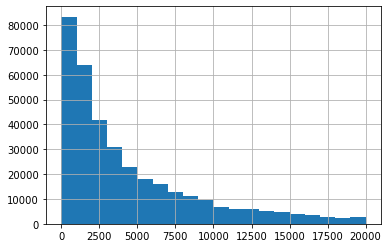

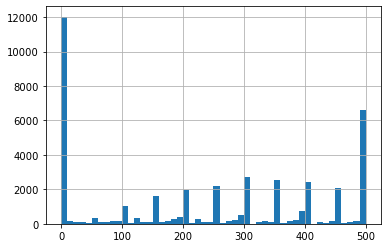

In [6]:
autos['Price'].hist(bins=20)
plt.show()
autos['Price'].hist(bins=50, range=[0,500])
plt.show()

In [7]:
autos = autos.loc[autos['Price']>100]
autos['Price'].describe()

count    340020.000000
mean       4602.498115
std        4514.920302
min         101.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

#### Brand
Со столбцом "Марка" проблем нет

In [8]:
autos['Brand'].value_counts()

volkswagen        73693
opel              37983
bmw               35535
mercedes_benz     31189
audi              28396
ford              24045
renault           17138
peugeot           10677
fiat               9206
seat               6651
mazda              5419
skoda              5419
smart              5148
citroen            4961
nissan             4761
toyota             4525
hyundai            3513
mini               3157
volvo              3099
mitsubishi         2896
honda              2695
sonstige_autos     2683
kia                2392
suzuki             2244
alfa_romeo         2203
chevrolet          1696
chrysler           1348
dacia               888
daihatsu            753
subaru              718
porsche             705
jeep                652
land_rover          533
daewoo              521
saab                512
jaguar              486
trabant             471
rover               451
lancia              446
lada                212
Name: Brand, dtype: int64

#### Model
У столбца Модель две проблемы: пропуски и одинаковое название моделей у автомобилей разных марок.  
Пропуски в столбце "Модель" встречаются у всех марок, причем, для марки sonstige_autos нет вообще ни одной модели. Модель - это очень важный показатель для определения цены, удалять столбец нельзя. Чтобы не удалять все записи для марки sonstige_autos, поставим фиктивное значение вместо названия модели. Остальные пропуски можно попытаться заполнить, обучив простую модель. Оставим это на будущее. Пока что просто удалим оставшиеся записи с пропусками в столбце модель.

In [9]:
brand_table = autos.pivot_table(index='Brand', values='Price', aggfunc='count')
brand_table['null'] = autos[autos['Model'].isnull()].pivot_table(index='Brand', values='Price', aggfunc='count')
brand_table['perc'] = (brand_table['null']/brand_table['Price']*100).round(1)
brand_table.sort_values(by='perc', ascending=False)

,Price,null,perc
Brand,,,
sonstige_autos,2683,2683,100.0
rover,451,68,15.1
trabant,471,65,13.8
peugeot,10677,812,7.6
daewoo,521,38,7.3
hyundai,3513,216,6.1
chrysler,1348,77,5.7
lada,212,12,5.7
mazda,5419,305,5.6


In [10]:
autos.loc[autos['Brand']=='sonstige_autos', 'Model'] = 'no_data'
autos = autos.dropna(subset=['Model'])

Теперь разберемся с повтором значений модели. Значение other, под которым объединены другие, по всей видимости, редко встречающиеся модели каждой марки, является вторым по популярности во всем датасете. Эти значения нельзя ни удалить - их слишком много, ни оставить как есть - это помешает хорошо обучиться алгоритму. Чтобы алгоритм не смешивал модели автомобилей с одинаковым названием, относящиеся к разным маркам (other  и другие, если они есть), создадим новый столбец, в котором объединим название марки и модели. В дальнейшем будем использовать в качестве признака именно его. Это решение также облегчит заполнение пропусков в других столбцах.

In [11]:
autos['Model'].value_counts().head(20)

golf           27992
other          23433
3er            19062
polo           12418
corsa          11930
astra          10364
passat          9785
a4              9595
c_klasse        8158
5er             7612
e_klasse        6594
a3              6008
focus           5718
fiesta          5530
a6              5347
2_reihe         4746
twingo          4717
transporter     4644
fortwo          4279
a_klasse        4112
Name: Model, dtype: int64

In [12]:
autos['BrandModel'] = autos['Brand'] + ' ' + autos['Model']
autos['BrandModel'].value_counts().head(20)

volkswagen golf           27992
bmw 3er                   19062
volkswagen polo           12418
opel corsa                11930
opel astra                10364
volkswagen passat          9785
audi a4                    9595
mercedes_benz c_klasse     8158
bmw 5er                    7612
mercedes_benz e_klasse     6594
audi a3                    6008
ford focus                 5718
ford fiesta                5530
audi a6                    5347
peugeot 2_reihe            4746
renault twingo             4717
volkswagen transporter     4644
smart fortwo               4279
mercedes_benz a_klasse     4112
opel vectra                4051
Name: BrandModel, dtype: int64

Поскольку признак категориальный, слишком редкие автомобили придется удалить - модель не сможет нормально обучиться и сделать прогноз по одному-двум значениям.

In [13]:
print(autos['BrandModel'].value_counts().tail(20))
rare_autos = autos.pivot_table(index='BrandModel', values='Price', aggfunc='count').query('Price<10').index
autos = autos.query('not BrandModel in @rare_autos')

dacia other                      21
daihatsu materia                 18
land_rover other                 18
audi 200                         17
lancia kappa                     14
volkswagen amarok                13
audi q3                          13
mercedes_benz gl                 12
lada samara                      11
lancia elefantino                10
lada kalina                       9
land_rover serie_2                8
bmw i3                            8
rover rangerover                  4
land_rover serie_3                3
rover discovery                   2
rover freelander                  2
land_rover range_rover_evoque     2
land_rover serie_1                1
rover defender                    1
Name: BrandModel, dtype: int64


#### DateCrawled и LastSeen
Все значения даты выгрузки анкеты из базы и даты последней активности пользователя находятся в коротком промежутке с 3 марта до 4 апреля 2016 года. Они никак не связаны со стоимостью автомобиля, поэтому их не имеет смысла включать в состав парамеров модели.

In [14]:
print('Date crawled:', autos['DateCrawled'].min(), 'to', autos['DateCrawled'].max())
print('Last seen:   ', autos['LastSeen'].min(), 'to', autos['LastSeen'].max())

Date crawled: 2016-03-05 14:06:22 to 2016-04-07 14:36:58
Last seen:    2016-03-05 14:15:08 to 2016-04-07 14:58:51


#### DateCreated
Слишком старые объявления, которые висят в базе больше одного-двух месяцев, скорее всего содержат недостоверную информацию и/или неадекватную цену, обучаться на них нельзя. Удалим строки, для которых объявление было создано раньше 1 марта 2016 года. В остальном значения в этом столбце не связаны со стоимостью автомобиля, поэтому столбец не имеет смысла включать в состав парамеров модели.

In [15]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325774 entries, 0 to 354368
Data columns (total 17 columns):
DateCrawled          325774 non-null object
Price                325774 non-null int64
VehicleType          298194 non-null object
RegistrationYear     325774 non-null int64
Gearbox              311832 non-null object
Power                325774 non-null int64
Model                325774 non-null object
Kilometer            325774 non-null int64
RegistrationMonth    325774 non-null int64
FuelType             302644 non-null object
Brand                325774 non-null object
NotRepaired          268255 non-null object
DateCreated          325774 non-null object
NumberOfPictures     325774 non-null int64
PostalCode           325774 non-null int64
LastSeen             325774 non-null object
BrandModel           325774 non-null object
dtypes: int64(7), object(10)
memory usage: 44.7+ MB


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


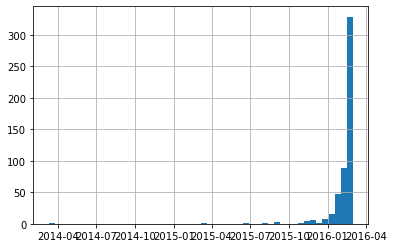

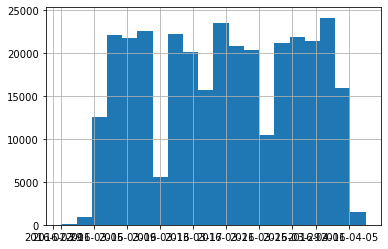

In [16]:
autos['DateCreated'] = pd.to_datetime(autos['DateCreated'])
limit_date = dt.datetime(2016,3,1)
autos['DateCreated'].hist(bins=50, range=(autos['DateCreated'].min(),limit_date))
plt.show()
autos['DateCreated'].hist(bins=20, range=(limit_date,autos['DateCreated'].max()))
plt.show()

In [17]:
autos = autos.loc[autos['DateCreated']>limit_date]
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325265 entries, 0 to 354368
Data columns (total 17 columns):
DateCrawled          325265 non-null object
Price                325265 non-null int64
VehicleType          297726 non-null object
RegistrationYear     325265 non-null int64
Gearbox              311336 non-null object
Power                325265 non-null int64
Model                325265 non-null object
Kilometer            325265 non-null int64
RegistrationMonth    325265 non-null int64
FuelType             302167 non-null object
Brand                325265 non-null object
NotRepaired          267834 non-null object
DateCreated          325265 non-null datetime64[ns]
NumberOfPictures     325265 non-null int64
PostalCode           325265 non-null int64
LastSeen             325265 non-null object
BrandModel           325265 non-null object
dtypes: datetime64[ns](1), int64(7), object(9)
memory usage: 44.7+ MB


Далее потребуется заполнять пропуски в столбцах типичными значениями для каждой марки. Введем функцию fill_by_typish.

In [18]:
def fill_by_typish(data, index_col, value_col, how='mean'):
    '''
    заполнение столбца value_col из data наиболее типичными значениями 
    для строк, сгруппированных по значениям столбца index_col
    варианты:
    - mean - среднее
    - median - медианное
    - most_frequent - наиболее частое значение
    '''
    
    if how=='mean':
        af = 'mean'
    elif how=='median':
        af = 'median'
    elif how=='most_frequent':
        af = lambda x: x.value_counts().index[0]
    else:
        print('fill_by_typish error: unknown "how" value =', how)
        return data

    table = data.pivot_table(values=value_col, index=index_col, aggfunc=af) 
    null_idx = data[value_col].isnull()
    for i in table.index:
        data.loc[(data[index_col]==i) & null_idx, value_col] = table.loc[i, value_col]   
    return data

#### FuelType
petrol и gasoline - это два обозначения бензина, объединим их. Оставшиеся пропуски заполним наиболее часто встречающимся значением для данной модели автомобиля.

In [19]:
autos['FuelType'].value_counts()

petrol      201699
gasoline     94548
lpg           4942
cng            536
hybrid         223
other          135
electric        84
Name: FuelType, dtype: int64

In [20]:
autos['FuelType'] = autos['FuelType'].replace('gasoline', 'petrol')
autos = fill_by_typish(autos, 'BrandModel', 'FuelType', how='most_frequent')
autos['FuelType'].value_counts()

petrol      319345
lpg           4942
cng            536
hybrid         223
other          135
electric        84
Name: FuelType, dtype: int64

#### Gearbox
Пропуски в столбце "тип КП" заполним наиболее частым значением для каждой модели

In [21]:
print(autos['Gearbox'].value_counts())

manual    248903
auto       62433
Name: Gearbox, dtype: int64


In [22]:
autos = fill_by_typish(autos, 'BrandModel', 'Gearbox', how='most_frequent')
autos['Gearbox'].value_counts()

manual    261110
auto       64155
Name: Gearbox, dtype: int64

#### NumberOfPictures
Все значения в столбце нулевые, он не содержит никакой полезной информации. Следовательно, его нет смысла включать в состав параметров.

In [23]:
autos['NumberOfPictures'].value_counts()

0    325265
Name: NumberOfPictures, dtype: int64

#### NotRepaired
Имеется много пропусков в столбце "ремонт". Заполним пропуски значением "no" (автомобиль был в ремонте). В пользу такого решения есть два аргумента. Это значение чаще встречается в выборке, что логично: подержанные автомобили, которые ни разу не были в ремонте - редкость. Кроме того, логично предположить, что пользователь мог оставить это поле незаполненным именно в том случае, если его автомобиль ремонтировался.

In [24]:
print(autos['NotRepaired'].value_counts())
autos['NotRepaired'] = autos['NotRepaired'].fillna('no')

no     236563
yes     31271
Name: NotRepaired, dtype: int64


#### RegistrationMonth
Пропусков нет, но значений месяцев не 12, а 13, т.к. одновременно встречаются значения 0 и 12. Есть две гипотезы относительно такого распределения. Можно предположить, что значение 0 маркирует пропуск. Другой вариант появляется, если посмотреть на гистограмму - выделяется не только 0, но и значения 3 и 6. Возможно, часть строк содержала данные о квартале, которые затем преобразовались в первый месяц квартала. В любом случае ценность данных о месяце регистрации для определения цены подержанных машин сомнительна, т.к. год регистрации вносит значительно более весомый вклад. Не будем включать этот столбец в состав парамеров модели, чтобы избежать ложных корреляций.

3     32590
6     29565
4     27448
5     27270
0     26752
7     25672
10    24679
11    22944
12    22814
9     22588
1     21692
8     21274
2     19977
Name: RegistrationMonth, dtype: int64


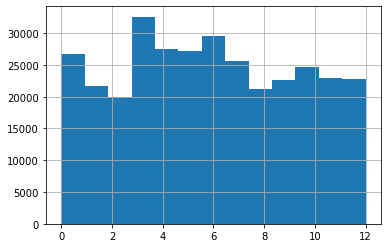

In [25]:
print(autos['RegistrationMonth'].value_counts())
autos['RegistrationMonth'].hist(bins=13)

#### RegistrationYear
Встречается много недостоверных данных, в частности, год регистрации меньше 1900 и больше 2016 (год выгрузки данных из базы). Удалим значения ниже 1960 года и позже 2015 (2016 год использовать не будем, т.к. база выгружалась в начале года, и пик на этом значении выглядит недостоверно)

count    325265.000000
mean       2003.907168
std          65.310096
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


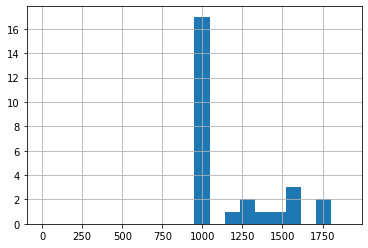

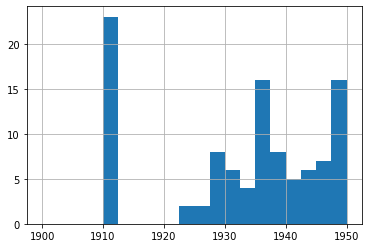

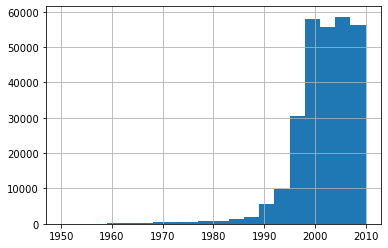

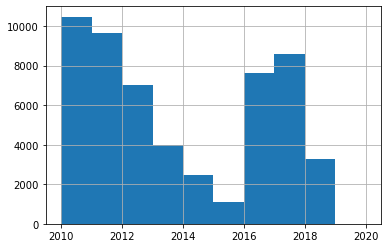

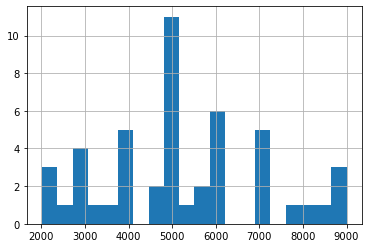

In [26]:
print(autos['RegistrationYear'].describe())
autos['RegistrationYear'].hist(bins=20, range=[0,1900])
plt.show()
autos['RegistrationYear'].hist(bins=20, range=[1900,1950])
plt.show()
autos['RegistrationYear'].hist(bins=20, range=[1950,2010])
plt.show()
autos['RegistrationYear'].hist(bins=10, range=[2010,2020])
plt.show()
autos['RegistrationYear'].hist(bins=20, range=[2020,9000])
plt.show()

In [27]:
autos = autos.loc[autos['RegistrationYear']>1960]
autos = autos.loc[autos['RegistrationYear']<2016]

#### Почтовый индекс
Почтовый индекс можно либо использовать в качестве категориального признака, если предположить, что стоимость автомобилей может сильно меняться от региона к региону, либо удалить, если такая зависимость не предполагается. В данном случае имеем 8137 уникальных значений почтового индекса, все они имеют одниковую структуру, самый частый индекс встречается в 811 строке, что не так много для нашей выборки. Можно предположить, что все пользователи из одной страны ЕС (Германия?). Нет оснований полагать, что цены будут сильно отличаться внутри одной страны, более вероятным представляется, что модель может найти ложные корреляции цены с индексами. На основании этого не будем включать почтовые индексы в состав признаков модели.

In [28]:
print(len(autos['PostalCode'].unique()))
print(autos['PostalCode'].value_counts().head(10))

8114
10115    802
65428    529
66333    276
52525    271
44145    267
60311    266
32257    262
13357    255
78224    254
51065    254
Name: PostalCode, dtype: int64


#### Power
Выделяется множество нулевых значений, которые по своей сути являются пропусками, также есть недостоверно высокие значения мощности - до 20000. Вначале удалим все недостоверные значения (меньше 20 л.с. и больше 400 л.с.), а затем заполним получившиеся пропуски типичными (медианными) значениями для данной марки.

count    305341.000000
mean        114.250337
std         178.312574
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


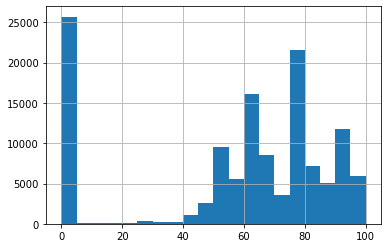

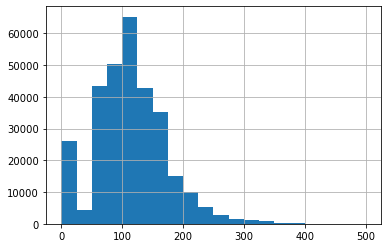

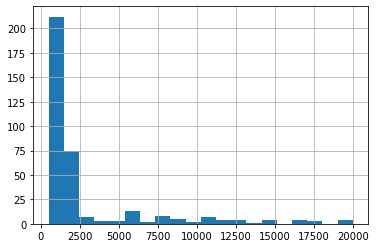

In [29]:
print(autos['Power'].describe())
autos['Power'].hist(bins=20, range=[0,100])
plt.show()
autos['Power'].hist(bins=20, range=[0,500])
plt.show()
autos['Power'].hist(bins=20, range=[500,20000])
plt.show()

In [30]:
autos['Power'] = autos['Power'].where(autos['Power']>=20)
autos['Power'] = autos['Power'].where(autos['Power']<400)

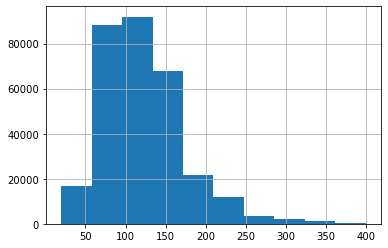

In [31]:
autos = fill_by_typish(autos, 'BrandModel', 'Power', how='median')
autos['Power'].hist()

#### VehicleType
Заполним пропуски наиболее типичными значениями для каждой модели.

In [32]:
autos['VehicleType'].value_counts()

sedan          86150
small          74022
wagon          61417
bus            27469
convertible    19233
coupe          14841
suv            11369
other           2783
Name: VehicleType, dtype: int64

In [33]:
autos = fill_by_typish(autos, 'BrandModel', 'VehicleType', how='most_frequent')
autos['VehicleType'].value_counts()

sedan          89810
small          76104
wagon          62257
bus            28406
convertible    19323
coupe          15062
suv            11591
other           2788
Name: VehicleType, dtype: int64

#### Kilometer
Имеется всего 13 значений пробега, причем подавляющее большинство автомобилей имеют пробег ровно 150 тыс. км. Похоже, что это категориальный признак, который нужно траковать таким образом: "менее 5 тыс. км.", "менее 10 тыс. км." ... "150 и более тыс. км."

150000    202716
125000     32562
100000     13161
90000      10547
80000       9203
70000       7941
60000       6939
50000       5763
40000       4579
30000       4042
5000        3480
20000       3420
10000        988
Name: Kilometer, dtype: int64


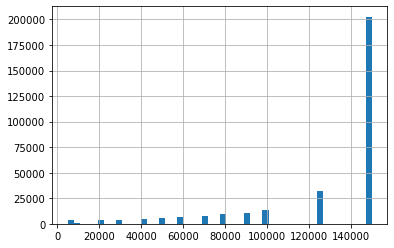

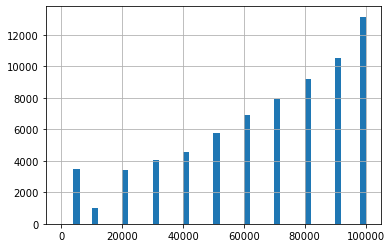

In [34]:
print(autos['Kilometer'].value_counts())
autos['Kilometer'].hist(bins=50)
plt.show()
autos['Kilometer'].hist(bins=50, range=(0,100000))
plt.show()

#### Результат

In [35]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305341 entries, 0 to 354368
Data columns (total 17 columns):
DateCrawled          305341 non-null object
Price                305341 non-null int64
VehicleType          305341 non-null object
RegistrationYear     305341 non-null int64
Gearbox              305341 non-null object
Power                305341 non-null float64
Model                305341 non-null object
Kilometer            305341 non-null int64
RegistrationMonth    305341 non-null int64
FuelType             305341 non-null object
Brand                305341 non-null object
NotRepaired          305341 non-null object
DateCreated          305341 non-null datetime64[ns]
NumberOfPictures     305341 non-null int64
PostalCode           305341 non-null int64
LastSeen             305341 non-null object
BrandModel           305341 non-null object
dtypes: datetime64[ns](1), float64(1), int64(6), object(9)
memory usage: 51.9+ MB


В результате подготовки данных из 354369 строк осталось 305341. Чтобы убедиться, что предобработка выполнена верно, посмотрим как изменились зависимости в данных

In [36]:
autos.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.529145,0.505834,-0.371311,0.076677,NaN,0.069758
RegistrationYear,0.529145,1.000000,0.152624,-0.290128,0.077183,NaN,0.040504
Power,0.505834,0.152624,1.000000,0.104669,0.043011,NaN,0.055817
Kilometer,-0.371311,-0.290128,0.104669,1.000000,-0.005520,NaN,-0.011344
RegistrationMonth,0.076677,0.077183,0.043011,-0.005520,1.000000,NaN,0.007167
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.069758,0.040504,0.055817,-0.011344,0.007167,NaN,1.000000


После предобработки заметно выросла корреляция цены с мощностью двигателя, появилась корреляция с годом регистрации. Посмотрим на графики рассеяния для значимых числовых признаков.

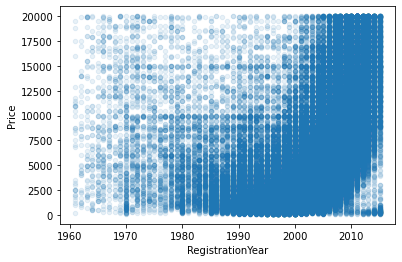

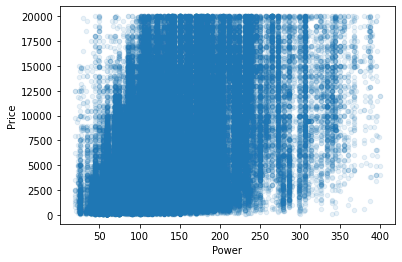

In [37]:
for col in ['RegistrationYear', 'Power']:
    autos.plot(x=col, y='Price', kind='scatter', alpha=0.1)
    plt.show()

Теперь посмотрим на графики с усами для категориальных признаков.

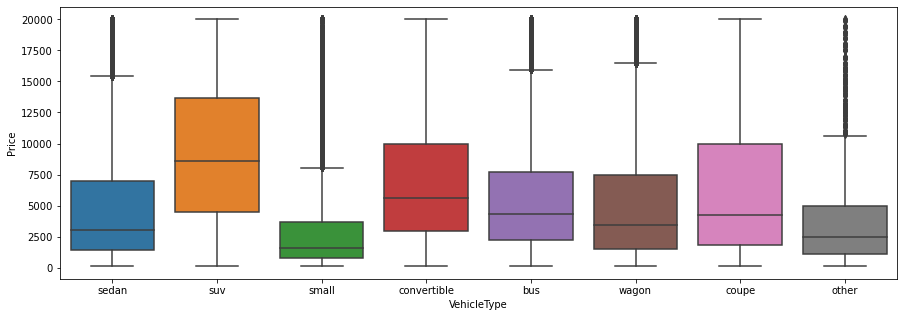

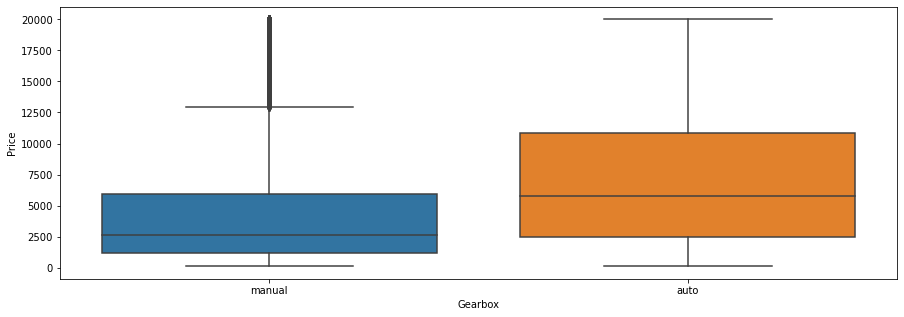

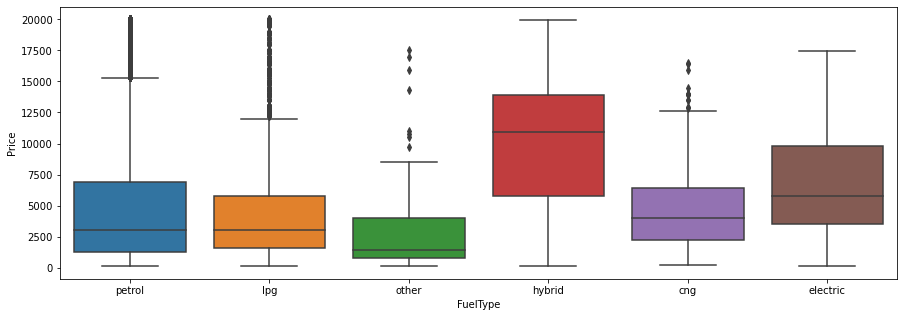

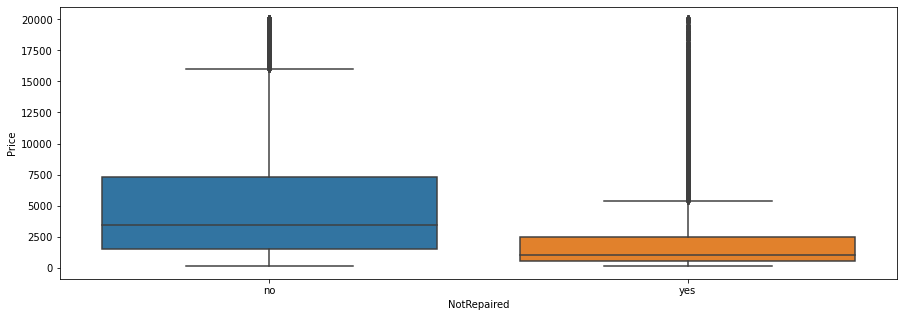

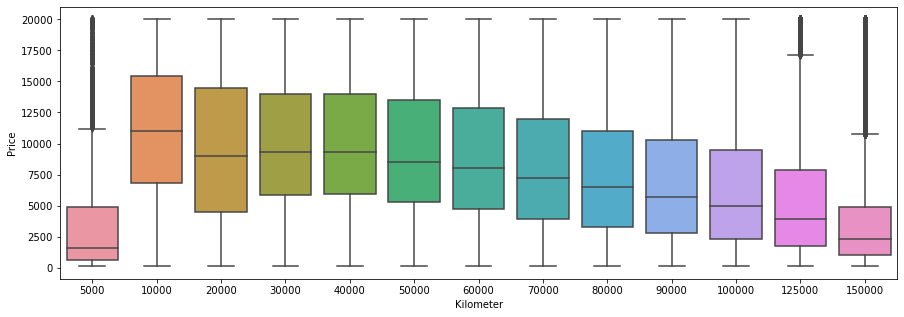

In [38]:
for col in ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Kilometer']:
    plt.figure(figsize=(15,5))
    sns.boxplot(data=autos, x=col, y='Price')
    plt.show()

Логике не поддаются два момента:  
- автомобили со значением "yes" в поле "NotRepared" значимо дешевле. Могу предположить, что на самом деле этот признак нужно понимать не "была машина в ремонте или нет", а "битая или нет", т.е. требует ли ремонта на момент размещения объявления
- автомобили с пробегом до 5 тыс. км. сильно дешевле остальных. Чтобы справиться с этим, попробуем дополнительно отсеять записи с недостоверным или редким соотношением возраста и пробега.

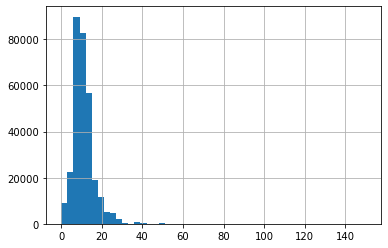

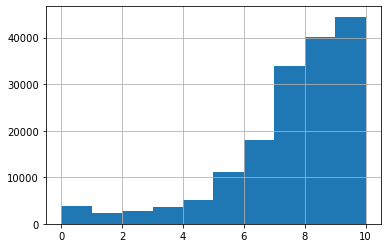

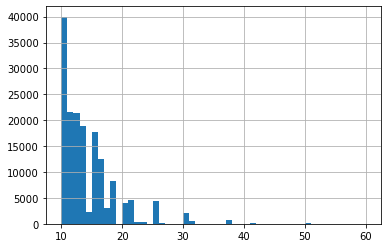

In [39]:
autos['RunPerYear'] = autos['Kilometer']/(2016 - autos['RegistrationYear'])/1000
autos['RunPerYear'].hist(bins=50)
plt.show()
autos['RunPerYear'].hist(bins=10, range=(0,10))
plt.show()
autos['RunPerYear'].hist(bins=50, range=(10,60))
plt.show()

Удалим записи, для которых пробег за год меньше 2 тыс. км или больше 30 тыс. км. В результате потеряем еще 8 тыс. записей, зато зависимость цены от пробега стала намного стройнее. Сам столбец RunPerYear не будем включать в состав параметров модели, т.к. у него наблюдается странная положительная корреляция с ценой.

In [40]:
autos = autos.loc[autos['RunPerYear']>=2]
autos = autos.loc[autos['RunPerYear']<=30]
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297535 entries, 0 to 354368
Data columns (total 18 columns):
DateCrawled          297535 non-null object
Price                297535 non-null int64
VehicleType          297535 non-null object
RegistrationYear     297535 non-null int64
Gearbox              297535 non-null object
Power                297535 non-null float64
Model                297535 non-null object
Kilometer            297535 non-null int64
RegistrationMonth    297535 non-null int64
FuelType             297535 non-null object
Brand                297535 non-null object
NotRepaired          297535 non-null object
DateCreated          297535 non-null datetime64[ns]
NumberOfPictures     297535 non-null int64
PostalCode           297535 non-null int64
LastSeen             297535 non-null object
BrandModel           297535 non-null object
RunPerYear           297535 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(6), object(9)
memory usage: 43.1+ MB


0.4787540463321159


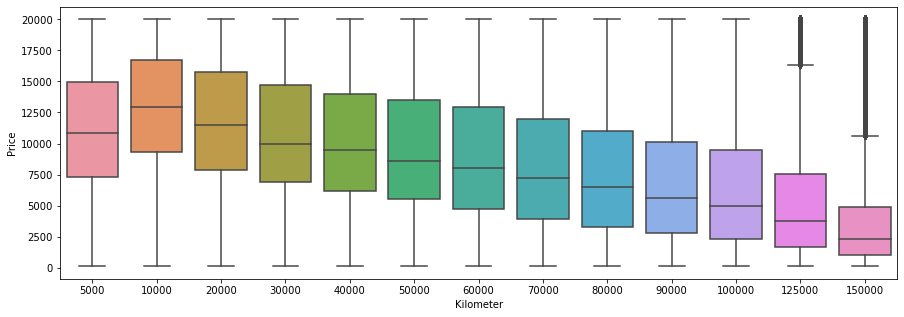

In [41]:
print(autos['Price'].corr(autos['RunPerYear']))
plt.figure(figsize=(15,5))
sns.boxplot(data=autos, x='Kilometer', y='Price')
plt.show()

### 1.3 Подготовка обучающей и тестовой выборки
Разобъем датасет на обучаующую и тестовую выборки в пропорции 4:1. Валидационную выборку выделять не будем, воспользуемся кросс-валидацией.

In [42]:
num_cols = ['RegistrationYear', 'Power', 'Kilometer']
cat_cols = ['VehicleType', 'Gearbox', 'FuelType', 'BrandModel', 'NotRepaired']

x = autos[num_cols + cat_cols]
y = autos['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
print('Обучающая выборка:', x_train.shape, y_train.shape)
print('Тестовая выборка: ', x_test.shape, y_test.shape)

x_train

Обучающая выборка: (238028, 8) (238028,)
Тестовая выборка:  (59507, 8) (59507,)


,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,FuelType,BrandModel,NotRepaired
326589,1999,75.0,150000,sedan,manual,petrol,volkswagen golf,no
114564,2003,109.0,150000,small,manual,petrol,citroen c3,yes
53558,2005,115.0,90000,bus,manual,petrol,volkswagen golf,no
241380,2008,135.0,150000,wagon,auto,petrol,citroen c5,no
63739,2005,170.0,150000,suv,auto,lpg,kia sportage,no
...,...,...,...,...,...,...,...,...
229420,2003,75.0,150000,small,manual,petrol,opel corsa,no
21115,1995,90.0,150000,wagon,manual,petrol,volkswagen golf,no
33457,2000,165.0,150000,wagon,manual,petrol,audi a6,yes
330962,2011,71.0,30000,small,auto,petrol,smart fortwo,no


Стандартизация численных признаков

In [43]:
scaler = StandardScaler()
scaler.fit(x_train[num_cols])
#x_train[num_cols] = pd.DataFrame(scaler.transform(x_train[num_cols]), columns=num_cols)
#x_test[num_cols] = pd.DataFrame(scaler.transform(x_test[num_cols]), columns=num_cols)
x_train[num_cols] = scaler.transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])
x_train

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,FuelType,BrandModel,NotRepaired
326589,-0.605783,-0.879070,0.578160,sedan,manual,petrol,volkswagen golf,no
114564,0.073347,-0.221744,0.578160,small,manual,petrol,citroen c3,yes
53558,0.412911,-0.105745,-1.186724,bus,manual,petrol,volkswagen golf,no
241380,0.922258,0.280917,0.578160,wagon,auto,petrol,citroen c5,no
63739,0.412911,0.957575,0.578160,suv,auto,lpg,kia sportage,no
...,...,...,...,...,...,...,...,...
229420,0.073347,-0.879070,0.578160,small,manual,petrol,opel corsa,no
21115,-1.284912,-0.589073,0.578160,wagon,manual,petrol,volkswagen golf,no
33457,-0.436000,0.860910,0.578160,wagon,manual,petrol,audi a6,yes
330962,1.431605,-0.956402,-2.951609,small,auto,petrol,smart fortwo,no


Кодирование категориальных признаков выполним двумя методами: OrdinalEncoder для градиентного бустинга и деревьев, OneHotEncoding для линейной регресии. Попутно будем сравнивать точность и скорость на разных моделях.

In [44]:
encoder = OrdinalEncoder()
encoder.fit(x_train[cat_cols])
x_train_ord = x_train.copy()
x_train_ord[cat_cols] = pd.DataFrame(encoder.transform(x_train[cat_cols]), columns=cat_cols, index=x_train.index)
x_train_ord[cat_cols] = x_train_ord[cat_cols].astype('int32')

x_test_ord = x_test.copy()
x_test_ord[cat_cols] = pd.DataFrame(encoder.transform(x_test[cat_cols]), columns=cat_cols, index=x_test.index)
x_test_ord[cat_cols] = x_test_ord[cat_cols].astype('int32')

x_train_ord

,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,FuelType,BrandModel,NotRepaired
326589,-0.605783,-0.879070,0.578160,4,1,5,264,0
114564,0.073347,-0.221744,0.578160,5,1,5,45,1
53558,0.412911,-0.105745,-1.186724,0,1,5,264,0
241380,0.922258,0.280917,0.578160,7,0,5,47,0
63739,0.412911,0.957575,0.578160,6,0,3,113,0
...,...,...,...,...,...,...,...,...
229420,0.073347,-0.879070,0.578160,5,1,5,181,0
21115,-1.284912,-0.589073,0.578160,7,1,5,264,0
33457,-0.436000,0.860910,0.578160,7,1,5,15,1
330962,1.431605,-0.956402,-2.951609,5,0,5,234,0


In [45]:
x_train_ohe = pd.get_dummies(x_train, drop_first=True)
x_train_ohe

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,BrandModel_volvo 850,BrandModel_volvo c_reihe,BrandModel_volvo other,BrandModel_volvo s60,BrandModel_volvo v40,BrandModel_volvo v50,BrandModel_volvo v60,BrandModel_volvo v70,BrandModel_volvo xc_reihe,NotRepaired_yes
326589,-0.605783,-0.879070,0.578160,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114564,0.073347,-0.221744,0.578160,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
53558,0.412911,-0.105745,-1.186724,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241380,0.922258,0.280917,0.578160,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
63739,0.412911,0.957575,0.578160,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229420,0.073347,-0.879070,0.578160,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21115,-1.284912,-0.589073,0.578160,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
33457,-0.436000,0.860910,0.578160,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
330962,1.431605,-0.956402,-2.951609,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. Обучение моделей

Для удобства введем метрику качества RMSE

In [46]:
def calc_rmse(target, prediction):
    return np.round(np.sqrt(mean_squared_error(target, prediction)),1)

rmse_score = make_scorer(calc_rmse, greater_is_better=False)
scoring = {'RMSE': rmse_score}

Заготовка таблицы для записи результатов

In [47]:
model_res = pd.DataFrame()

Сразу определим, какой результат даст DummyRegressor

In [48]:
dummy = DummyRegressor(strategy='median')
dummy.fit(x_train, y_train)
y_dummy = dummy.predict(x_train)
res = calc_rmse(y_train, y_dummy)
print('Dummy RMSE =', res)
model_res.loc['dummy','RMSE'] = res

Dummy RMSE = 4872.2


Создадим функции, автоматизирующие перебор требуемых параметров, сохранение результатов и вывод их на график. Для оценки длительности обучения и прогноза будем использовать вывод функций cross_validate и GridSearchCV. Это не совсем корректно в абсолютных величинах, т.к. кросс-валидация выполняется дольше, чем просто обучение и предсказание. Но это дает представление о соотношении скорости работы разных моделей.

In [49]:
def cv_score(model, features, target, scoring, model_name=''):
    scoring_labels = list(scoring.keys())
    results = cross_validate(model, features, target, cv=5, scoring=scoring, n_jobs=-1)
    
    # качество
    for i in scoring_labels:
        res = abs(results['test_'+i]).mean().round(2)
        if model_name:
            model_res.loc[model_name, i] = res
        print(i, res)
        
    # время обучения
    fit_time = results['fit_time'].mean().round(2)
    score_time = results['score_time'].mean().round(2)
    print('fit time ', fit_time)
    print('score time ', score_time)
    if model_name:
        model_res.loc[model_name, 'train time'] = fit_time
        model_res.loc[model_name, 'predict time'] = score_time

In [50]:
def compare_hyperparams(x, results, labels='', title='', xlabel='', treshold=0):
    '''
    Функция выводит графики зависимости выбранных метрик исследуемой модели от значения гиперпараметра
    Входные параметры:
    - х - значения гиперпараметра
    - results - массив результатов
    - label - название результата (легенда линии)
    - title - название модели (подпись графика)
    - xlabel - название изменяемого гиперпараметра (подпись оси Х)
    - treshold - пороговое значение (прямая на линия на графике, не обязательный параметр)
    '''
    fig, ax = plt.subplots(figsize=(10,4))
    if treshold:
        ax.plot([min(x),max(x)],[treshold,treshold], '--r', linewidth=1)
    for i in range(len(results)):
        ax.plot(x, results[i], marker='.', label=labels[i])
    ax.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

In [51]:
def compare_hyperparams_heatmap(x1, x2, y, title='', label=['','']):
    '''
    функция выводит график типа "heatmap" зависимости качества исследуемой модели от значений двух гиперпараметров
    х1 - значения гиперпараметра 1
    х2 - значения гиперпараметра 2
    y - значение метрики в виде одномерного массива (результат работы функции GridSearchCV.cv_results_['...'])
    title - название модели (подпись графика)
    label - массив с названиями двух гиперпараметров (подписи осей Х и Y)
    '''
    y = y.reshape(len(x1), len(x2))

    ysize = len(x1) if len(x1)<16 else 16
    xsize = len(x2) if len(x2)<16 else 16
    fig, ax = plt.subplots(figsize=(xsize,ysize))
    im = ax.imshow(y, cmap='coolwarm')
    plt.title(title)
    
    cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)

    ax.set_xticks(np.arange(len(x2)))
    ax.set_yticks(np.arange(-0.5,len(x1)+0.5))
    ax.set_xticklabels(x2)
    ax.set_yticklabels(x1)
    ax.set_xlabel(label[1])
    ax.set_ylabel(label[0])

    for i in range(len(x1)):
        for j in range(len(x2)):
            text = ax.text(j, i, y[i, j], ha="center", va="center", color="k", fontsize=8)
    plt.show()

In [52]:
def cv_grid(model, parameters, features, target, scoring, model_name=''):
    '''
    Функция проверяет качество и скорость обучения модели при изменении одного гиперпарамера, 
    выводит результат на график и сохраняет в таблицу model_res
    Входные параметры:
    - model - модель
    - parameters - массив результатов
    - features - признаки
    - target - целевой признак
    - scoring - словарь используемых метрик вида {название: функция}, основная метрика при определении качества модели - первая
    - model_name - имя модели для записи в таблицу результатов
    '''
    scoring_labels = list(scoring.keys())
    parameter_values = list(parameters.values())
    parameter_keys = list(parameters.keys())
    
    grid = GridSearchCV(model, parameters, scoring=scoring, refit=scoring_labels[0], n_jobs=-1, cv=5)
    grid.fit(features, target)

    # качество
    results = []
    for i in scoring_labels:
        res = -grid.cv_results_['mean_test_'+i].round(2)
        results.append(res)
        if model_name:
            model_res.loc[model_name, i] = res.min()
        title = model_name + ' (' + i + ')'
        
        # графики качества
        if len(parameters)==1:
            compare_hyperparams(list(parameters.values())[0], results, scoring_labels, xlabel=list(parameters.keys())[0], 
                        title=model_name)
        elif len(parameters)==2:  
            compare_hyperparams_heatmap(parameter_values[0], parameter_values[1], res, label=parameter_keys, title=model_name)

    # время
    fit_time = grid.cv_results_['mean_fit_time']
    score_time = grid.cv_results_['mean_score_time']
    if model_name:
        best_param = grid.best_index_
        model_res.loc[model_name, 'train time'] = fit_time[best_param].round(2)
        model_res.loc[model_name, 'predict time'] = score_time[best_param].round(2)
    # графики времени
    if len(parameters)==1:
        compare_hyperparams(list(parameters.values())[0], [fit_time, score_time], ['fit time', 'score time'], 
                            xlabel=list(parameters.keys())[0], title=model_name)
        
    print('Best params', grid.best_params_)
    for i in range(len(results)):
        print('Best', scoring_labels[i], min(results[i]))

### 2.1 Линейная регрессия

In [53]:
%%time
cv_score(LinearRegression(), x_train_ohe, y_train, scoring, 'LinearRegression')

RMSE 2440.92
fit time  9.95
score time  0.12
Wall time: 18 s


### 2.2 Лассо

In [54]:
%%time
cv_score(Lasso(), x_train_ohe, y_train, scoring, 'Lasso')

RMSE 2481.82
fit time  24.04
score time  0.15
Wall time: 35 s


Лассо в данном случае по всем параметрам хуже, чем линейная регрессия

### 2.3 Дерево решений
_Здесь и далее не привожу расчет для OHE, т.к. время выполнения удручает_

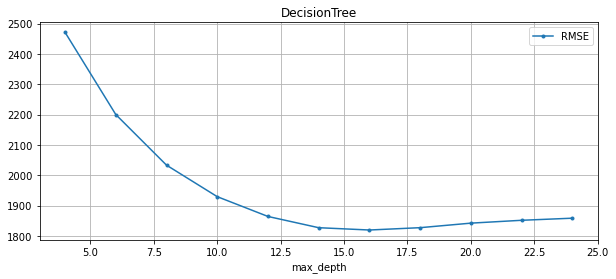

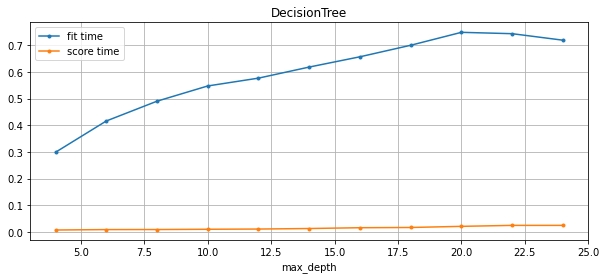

Best params {'max_depth': 16}
Best RMSE 1820.06
Wall time: 10 s


In [55]:
%%time
cv_grid(DecisionTreeRegressor(random_state=123), {'max_depth': range(4,25,2)}, x_train_ord, y_train, scoring, 'DecisionTree')

Результат намного лучше, чем у линейных моделей. но работает медленнее. Точность для OHE и Ordinal Encoding одинаковая, но Ordinal в несколько раз быстрее

### 2.4 Ближайшие соседи

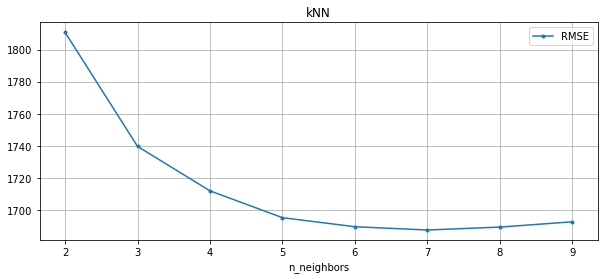

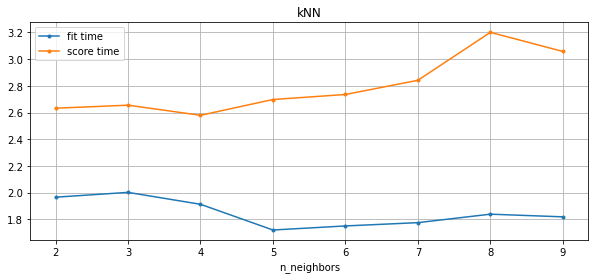

Best params {'n_neighbors': 7}
Best RMSE 1687.72
Wall time: 50 s


In [56]:
%%time
model = KNeighborsRegressor()
cv_grid(model, {'n_neighbors': range(2,10)}, x_train_ord, y_train, scoring, 'kNN')

Точность при 7 соседях выше, чем у дерева решений. Скорость работы при использовании OHE крайне низкая. От других моделей отличается тем, что время прогноза выше, чем время обучения.

### 2.5 Случайный лес

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished


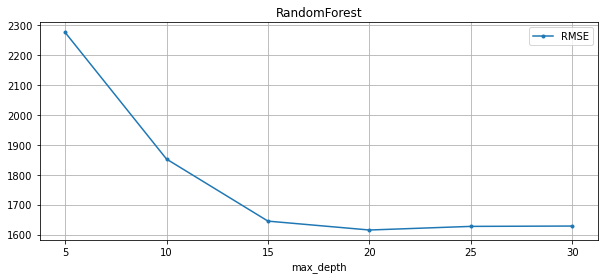

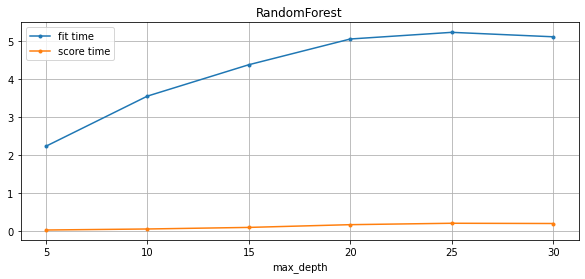

Best params {'max_depth': 20}
Best RMSE 1615.5
Wall time: 40.3 s


In [57]:
%%time
model = RandomForestRegressor(random_state=123, n_estimators=10, verbose=2)
cv_grid(model, {'max_depth': range(5,31,5)}, x_train_ord, y_train, scoring, 'RandomForest')

In [58]:
%%time
model = RandomForestRegressor(random_state=123, n_estimators=100, max_depth=20, n_jobs=-1, verbose=1)
cv_score(model, x_train_ord, y_train, scoring, 'RandomForest100')

RMSE 1579.56
fit time  41.42
score time  1.31
Wall time: 1min 2s


Случайный лес даже при малом (10) количестве деревьев показал себя лучше, чем дерево решений и соседи. Если увеличить кол-во итераций до 100, то точность ожидает возрастает, но не очень сильно, а вот затрачиваемое время - в разы.  

### 2.5 LightGBM

Подготовим датасет для LGB

In [59]:
lgb_train_data = lgb.Dataset(x_train_ord, label=y_train, categorical_feature=cat_cols, free_raw_data=False)
lgb_train_data.construct()

Введем функцию для автоматизации кросс-валидации и вывода результатов с использованием метода cv библиотеки lgb. Ей удобно пользоваться, чтобы оценить изменение качества модели при увеличении кол-ва итераций.

In [60]:
def lgb_cv (lgb_data, cat_cols, params={}):
    param = params
    param['metric'] = 'rmse'
    res = lgb.cv(param, lgb_data, nfold=5)
    plt.plot(res['rmse-mean'])
    plt.grid()
    print('Best RMSE', min(res['rmse-mean']).round(2))
    print('Best iteration', np.argmin(res['rmse-mean']))
    print('Last RMSE', res['rmse-mean'][-1].round(2))

Проверим результат с гиперпараметрами по умолчанию

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best RMSE 1600.23
Best iteration 99
Last RMSE 1600.23


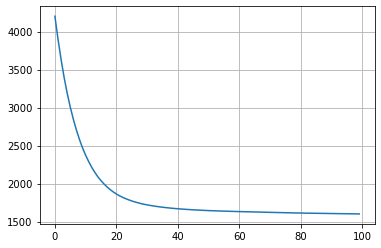

In [61]:
lgb_cv(lgb_train_data, cat_cols)

Точность сравнима со случайным лесом. Проверим, как влияют на модель гиперпарамеры learning_rate, max_depth и num_leaves.

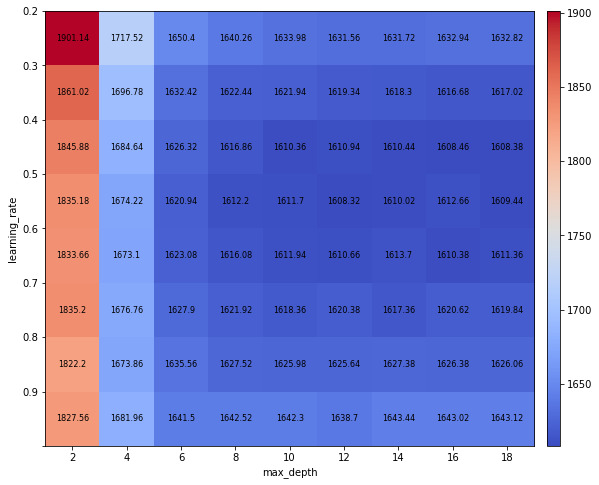

Best params {'learning_rate': 0.5, 'max_depth': 12}
Best RMSE 1608.32
Wall time: 2min 34s


In [62]:
%%time
lgbr = lgb.LGBMRegressor(boosting_type='gbdt', random_state=123)
parameters = {'learning_rate': np.arange(0.2, 1, 0.1).round(1), 'max_depth': range(2, 20, 2)}
cv_grid(lgbr, parameters, x_train_ord, y_train, scoring)

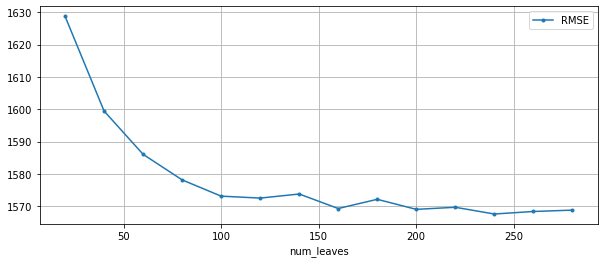

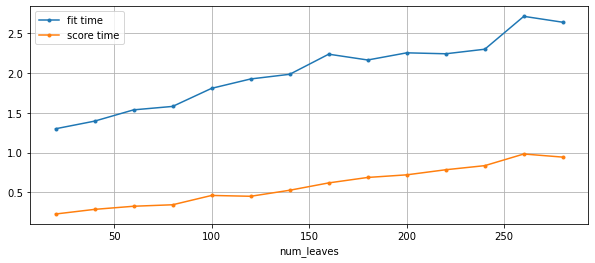

Best params {'num_leaves': 240}
Best RMSE 1567.66
Wall time: 48.9 s


In [63]:
%%time
lgbr = lgb.LGBMRegressor(boosting_type='gbdt', random_state=123, learning_rate=0.5, max_depth=12)
parameters = {'num_leaves': range(20, 300, 20)}
cv_grid(lgbr, parameters, x_train_ord, y_train, scoring)

После 200 листьев качество растет слишком медленно, остановимся на этом значении. Зафиксируем лучшие значения гиперпараметров и проверим, как будет меняться результат с ростом кол-ва итераций.

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best RMSE 1559.98
Best iteration 73
Last RMSE 1583.43


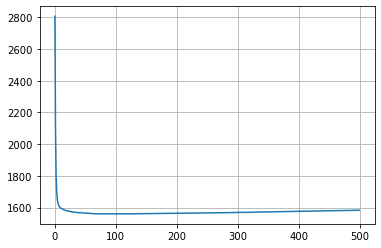

In [64]:
lgb_cv(lgb_train_data, cat_cols, 
       {'learning_rate': 0.5, 'max_depth': 12, 'num_leaves': 200, 'n_estimators': 500})

Как видно по графику, увеличение количества итераций выше 50 не приводит к заметному повышению качества. Наоборот, после 200 наблюдается ухудшение из-за переобучения модели. Остановимся на 100 итерациях. Исследуем качество и скорость финальной версии модели lgb.

In [65]:
%%time
lgbr = lgb.LGBMRegressor(boosting_type='gbdt', random_state=123, n_estimators=100, 
                         learning_rate=0.5, max_depth=12, num_leaves=200)
cv_score(lgbr, x_train_ord, y_train, scoring, 'LGB')

RMSE 1569.1
fit time  2.63
score time  0.74
Wall time: 6.11 s


### 2.6 CatBoost

Подготовим датасет для CatBoost

In [66]:
train_pool = cbs.Pool(x_train, y_train, cat_features=cat_cols)
model = cbs.CatBoostRegressor(iterations=20, loss_function='RMSE', random_state=123)

Исследуем зависимость качества модели от гиперпараметров learning_rate, max_depth и l2_leaf_reg

In [67]:
model = cbs.CatBoostRegressor(iterations=10, loss_function='RMSE', random_state=123)
parameters = {'learning_rate': np.arange(0.2, 1, 0.1), 'max_depth': range(2, 20, 2)}
grid_search_result = model.grid_search(parameters, X=train_pool, plot=True, verbose=False, refit=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 2613.795579
bestIteration = 9


bestTest = 2352.008503
bestIteration = 9


bestTest = 2264.286445
bestIteration = 9


bestTest = 2226.837045
bestIteration = 9


bestTest = 2215.896502
bestIteration = 9


bestTest = 2236.462584
bestIteration = 9


bestTest = 2219.495861
bestIteration = 9


bestTest = 2218.451669
bestIteration = 9


bestTest = 2378.187225
bestIteration = 9


bestTest = 2132.992118
bestIteration = 9


bestTest = 2085.556399
bestIteration = 9


bestTest = 2016.57488
bestIteration = 9


bestTest = 2002.39355
bestIteration = 9


bestTest = 2004.484579
bestIteration = 9


bestTest = 2020.751482
bestIteration = 9


bestTest = 2016.045806
bestIteration = 9


bestTest = 2260.129365
bestIteration = 9


bestTest = 2032.798693
bestIteration = 9


bestTest = 1979.250673
bestIteration = 9


bestTest = 1940.576422
bestIteration = 9


bestTest = 1921.918124
bestIteration = 9


bestTest = 1911.982949
bestIteration = 9


bestTest = 1915.418238
bestIteration = 9


bestTest = 1

In [68]:
model = cbs.CatBoostRegressor(iterations=10, loss_function='RMSE', random_state=123, learning_rate=0.5, max_depth=16)
parameters = {'l2_leaf_reg': range(1, 5)}
grid_search_result = model.grid_search(parameters, X=train_pool, plot=True, verbose=False, refit=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1744.63893
bestIteration = 9


bestTest = 1739.819668
bestIteration = 9


bestTest = 1737.962285
bestIteration = 9


bestTest = 1735.937508
bestIteration = 9



Зафиксируем лучшие гиперпараметры и выполним кросс-валидацию, чтобы оценить изменение качества модели от кол-ва итераций

In [69]:
%%time
params = {"iterations": 50,
          "learning_rate": 0.5,
          "depth": 16,
          "l2_leaf_reg": 1,
          "loss_function": "RMSE",
          "verbose": False}
scores = cbs.cv(train_pool, params, fold_count=3, plot="True")
model_res.loc['CatBoost','RMSE'] = scores['test-RMSE-mean'].round(2).min()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 2min 36s


Уже после 10 итераций кривая RMSE становится пологой, а после 50 итераций качество растет крайне медленно (для экономии времени не стал выводить график дальше).

In [70]:
%%time
cbr = cbs.CatBoostRegressor(iterations=50, loss_function='RMSE', random_state=123, 
                            learning_rate=0.7, max_depth=16, l2_leaf_reg=1)
res = cbr.fit(train_pool)

0:	learn: 2577.8642927	total: 106ms	remaining: 5.18s
1:	learn: 2094.1002996	total: 1.15s	remaining: 27.6s
2:	learn: 1891.4143624	total: 2.19s	remaining: 34.4s
3:	learn: 1825.1607987	total: 3.21s	remaining: 36.9s
4:	learn: 1752.8980379	total: 4.23s	remaining: 38.1s
5:	learn: 1711.7291786	total: 5.26s	remaining: 38.6s
6:	learn: 1686.7696035	total: 6.28s	remaining: 38.6s
7:	learn: 1665.5150359	total: 7.3s	remaining: 38.3s
8:	learn: 1636.7272020	total: 8.32s	remaining: 37.9s
9:	learn: 1624.0962849	total: 9.34s	remaining: 37.4s
10:	learn: 1598.6810793	total: 10.4s	remaining: 36.7s
11:	learn: 1579.8337432	total: 11.4s	remaining: 36.1s
12:	learn: 1564.3735411	total: 12.4s	remaining: 35.3s
13:	learn: 1551.0226295	total: 13.4s	remaining: 34.5s
14:	learn: 1541.6065201	total: 14.4s	remaining: 33.6s
15:	learn: 1530.5473251	total: 15.4s	remaining: 32.8s
16:	learn: 1521.5320575	total: 16.4s	remaining: 31.9s
17:	learn: 1510.0570719	total: 17.4s	remaining: 31s
18:	learn: 1495.0820199	total: 18.5s	rema

Время обучения составило 55 секунд. Внесем это значение в таблицу

In [71]:
model_res.loc['CatBoost','train time'] = 55

# 3. Анализ моделей

In [72]:
model_res

,RMSE,train time,predict time
dummy,4872.20,NaN,NaN
LinearRegression,2440.92,9.95,0.12
Lasso,2481.82,24.04,0.15
DecisionTree,1820.06,0.66,0.02
kNN,1687.72,1.78,2.84
RandomForest,1615.50,5.06,0.17
RandomForest100,1579.56,41.42,1.31
LGB,1569.10,2.63,0.74
CatBoost,1645.61,55.00,NaN


Все модели прошли проверку на адекватность: они справляются лучше, чем предсказание медианного значения целевого признака. Ожидаемый результат: с увеличением сложности модели растет качество, но уменьшается скорость.  
Лучший результат при кросс-валидации показала LightGBM (RMSE 1569 евро), немного хуже RandomForest при 100 деревьях (1579 евро) и CatBoost (1645). При этом LightGBM оказалась быстрее других тяжелых моделей.  
В задании не указано, какие качество предсказания, скорость обучения и предсказания являются допустимыми, так что проверим тестовую выборку на модели LightGBM.

In [73]:
params = {
    'boosting_type': 'gbdt',
    'n_estimators': 100,
    'learning_rate': 0.4,
    'max_depth': 12,
    'num_leaves': 200}
%time lgbr = lgb.train(params, lgb_train_data, y_train)
%time y_predict = lgbr.predict(x_test_ord)
print('test RMSE', calc_rmse(y_test, y_predict))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Wall time: 1.02 s
Wall time: 277 ms
test RMSE 1510.3


RMSE составил 1510 евро, что даже лучше, чем при валидации. Без кросс-валидации время обучения составило 1 с, время предсказания - 0,3 с. Посмотрим на распределение реальных и предсказанных цен.

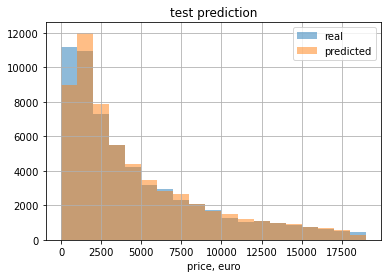

In [74]:
bins = range(0, 20000, 1000)
plt.hist(y_test, bins=bins, alpha=0.5, label='real')
plt.hist(y_predict, bins=bins, alpha=0.5, label='predicted')
plt.xlabel('price, euro')
plt.title('test prediction')
plt.grid()
plt.legend()
plt.show()

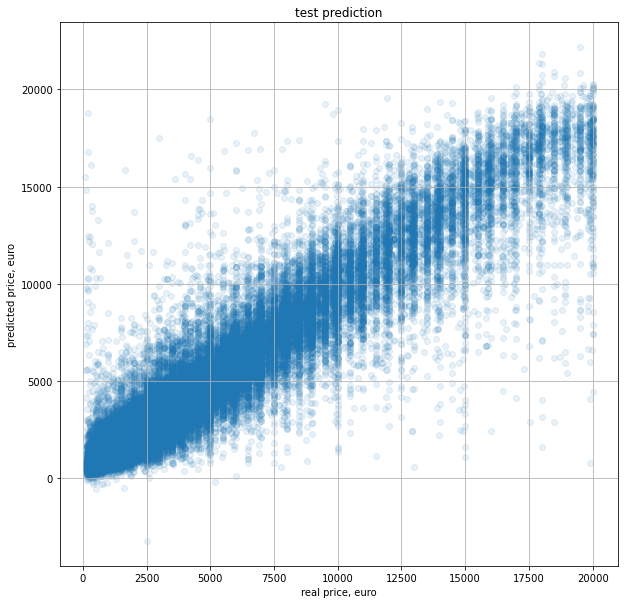

In [75]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(y_test, y_predict, alpha=0.1)
plt.xlabel('real price, euro')
plt.ylabel('predicted price, euro')
plt.title('test prediction')
plt.grid()
plt.show()

In [76]:
print('Прогнозов ниже нуля:', sum(y_predict < 0))
print('Пронозов выше 20 тыс. евро:', sum(y_predict > 20000))

Прогнозов ниже нуля: 17
Пронозов выше 20 тыс. евро: 23


Гистограмма и график рассеяния показывают, что модель ведет себя довольно адекватно. Основная масса предсказаний близка к реальным значениям, но и разброс немалый, за счет чего и получается такая большая ошибка. Модель редко предсказывает самые низкие и самые высокие значения целевого признака, но при этом 17 предсказанных значений оказались меньше нуля. Такие ситуации нужно отслеживать и поправлять результат модели перед выдачей.

## Вывод
Были исследованы модели линейная регрессия, лассо, дерево решений, kNN, случайный лес, а также градиентный бустинг в реализациях LightGBM и CatBoost. LightGBM показал лучший результат по точности и превзошел другие тяжелые модели по скорости. На тестовой выборке было получено значение RMSE 1510 евро.  
Полученый результат нельзя назвать идеальным, ошибка слишком велика, чтобы внедрять модель в сервис. Исходные данные были не очень хороши: пропуски, выбросы, лишние сведения. Их обработка сильно влияет на качество модели. Для улучшения качества прогноза нужно продолжить работать с данными.